In [1]:
import tensorflow as tf
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


### Sample-level sentence removal

In [ ]:
# saved_path = '../elemnet/model/alignn_matbert-base-cased_robo_prop_formation_energy_peratom'
# # elemnet/sample/alignn_matbert-base-cased_robo_prop_formation_energy_peratom.config

# with open('{}.json'.format(saved_path), 'r') as json_file:
#     json_savedModel= json_file.read()
# model = tf.keras.models.model_from_json(json_savedModel) 

# model.load_weights("{}.h5".format(saved_path))

# print("Loaded model from disk")

# adam = optimizers.Adam(lr=0.0001)
# model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=adam, metrics=['mean_absolute_error'])

In [ ]:
prop = "mbj_bandgap"
skips = ['no_removal', '2', '31', '37', '44', '60']

text = "robo"
predict_map = {}
selected_samples = ["JVASP-1151.vasp"]
for skip in skips:
    if skip == "no_removal":
        test_path = f'/data/yll6162/alignntl_dft_3d/tl_dataset/dataset_alignn_matbert-base-cased_{text}_prop_{prop}_test.csv'
    else:
        test_path = f'/data/yll6162/alignntl_dft_3d/tl_dataset/dataset_alignn_matbert-base-cased_{text}_mask_{skip}_prop_{prop}.csv'

    saved_path = f'/scratch/yll6162/CrossPropertyTL/elemnet/model/alignn_matbert-base-cased_{text}_prop_{prop}'
    # if prop in ["slme", "spillage"]:
    #     saved_path = f'/scratch/yll6162/CrossPropertyTL/elemnet/model/alignn_bert-base-uncased_{text}_prop_{prop}'
    # elemnet/sample/alignn_matbert-base-cased_{text}_prop_formation_energy_peratom.config
    with open('{}.json'.format(saved_path), 'r') as json_file:
        json_savedModel= json_file.read()
    model = tf.keras.models.model_from_json(json_savedModel) 
    model.load_weights("{}.h5".format(saved_path))
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=adam, metrics=['mean_absolute_error'])
    pred = pd.read_csv(test_path, index_col=0)
    if skip == "no_removal":
        pred = pred[pred.ids.isin(selected_samples)]
        pred_elem = pred[pred.columns[:-2]]
    else:
        pred_elem = pred[pred.columns[:-4]]
    # print(pred.head())
    new_x_pred = pred_elem.values
    new_x_pred = np.asarray(new_x_pred, dtype=np.float)
    y_pred = pred[[prop]]
    new_y_pred = np.array(y_pred)
    new_y_pred.shape = (len(new_y_pred),)
    predictions = model.predict(new_x_pred, batch_size=32)
    predict_map[skip] = predictions[0]
results_df = pd.DataFrame(predict_map)
results_df = results_df.transpose()

In [ ]:
# Calculate the absolute percentage difference
no_removal_value = df['no_removal'].iloc[0]
df_diff = df.apply(lambda x: abs((x - no_removal_value) / no_removal_value) * 100)

# Combine the original DataFrame with the calculated percentage difference
df_diff.index = ['%|diff|']
result_df = pd.concat([df, df_diff])
result_df = result_df.transpose()

# Defining the function to categorize based on the given ranges
thresholds = [1.5, 1.7, 1.9, 2.1, 2.3]
def categorize(diff, thresholds=[1.5, 1.7, 1.9, 2.1]):
    if diff <= thresholds[0]:
        return 0
    elif thresholds[0] < diff <= thresholds[1]:
        return 1
    elif thresholds[1] < diff <= thresholds[2]:
        return 2
    elif thresholds[2] < diff <= thresholds[3]:
        return 3
    else:
        return 4

# Applying the categorization function to create a new column
result_df['category'] = result_df['%|diff|'].apply(lambda x: categorize(x, thresholds))


words_positions_and_darkness = []
for i in range(1,len(result_df)):
    words_positions_and_darkness.append((int(result_df.index[i]), int(result_df['category'][i])))
words_positions_and_darkness.append((10, 1))

def highlight_words_with_varied_darkness(paragraph, words_positions_and_darkness):
    """
    Highlights words in a paragraph with varied levels of darkness given their positions and darkness levels.
    
    :param paragraph: str, the paragraph of text.
    :param words_positions_and_darkness: list of tuples, where each tuple contains the position (int) of the word and the level of darkness (float from -0.5 to 1).
    :return: str, the paragraph with highlighted words.
    """
    # Define a mapping from darkness levels to RGB color codes for background colors
    darkness_to_color = {
        0: '\033[48;2;250;240;112m',
        1: '\033[48;2;253;221;85m',
        2: '\033[48;2;213;224;88m',   
        3: '\033[48;2;155;203;73m',    
        4: '\033[48;2;110;190;69m',
    }
    
    words = paragraph.split()
    
    # Apply the correct darkness level for each word
    for pos, darkness in words_positions_and_darkness:
        if pos < len(words):
            words[pos] = f"{darkness_to_color[darkness]}{words[pos]}\033[0m"
    
    return ' '.join(words)

# Example usage:
paragraph = "MgB2 is hexagonal omega structure structured and crystallizes in the hexagonal P6/mmm space group. Mg(1) is bonded to twelve equivalent B(1) atoms to form a mixture of edge and face-sharing MgB12 cuboctahedra. All Mg(1)-B(1) bond lengths are 2.50 Å. B(1) is bonded in a 9-coordinate geometry to six equivalent Mg(1) and three equivalent B(1) atoms. All B(1)-B(1) bond lengths are 1.77 Å."

# words_positions_and_darkness = [zip(result_df.index, result_df['category'])]
highlighted_paragraph = highlight_words_with_varied_darkness(paragraph, words_positions_and_darkness)
print(highlighted_paragraph)


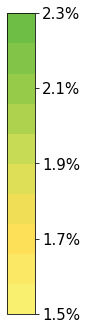

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Specified RGB values
colors = [
    (0.9804, 0.9412, 0.4392),  # (250, 240, 112)
    (0.9922, 0.8667, 0.3333),  # (253, 221, 85)
    (0.8353, 0.8784, 0.3451),  # (213, 224, 88)
    (0.6078, 0.7961, 0.2863),  # (155, 203, 73)
    (0.4314, 0.7451, 0.2706)   # (110, 190, 69)
]


# Associated texts
texts = [str(thre) + "%" for thre in thresholds]
# ['1.5%', '1.7%', '1.9%', '2.1%', '2.3%']

# Create a custom colormap with gradual changes between the specified colors
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=10)

# Create a colorbar
fig, ax = plt.subplots(figsize=(0.5, 11))
fig.subplots_adjust(bottom=0.5)

# Define the colorbar
norm = plt.Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='vertical'
)

# Set the ticks and their labels
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks(np.linspace(0, 1, len(texts)))
cbar.set_ticklabels(texts)
plt.savefig('colorbar.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()


In [22]:
prop = 'formation_energy_peratom'
test_path = '/data/yll6162/alignntl_dft_3d/tl_dataset/dataset_alignn_matbert-base-cased_robo_skip_4_prop_formation_energy_peratom.csv'
# test_path = '../data/sample/sample_test_set.csv'
pred = pd.read_csv(test_path, index_col=0) 
# pred = pd.read_csv(test_path) 
pred_elem = pred[pred.columns[:-4]]

new_x_pred = pred_elem.values
new_x_pred = np.asarray(new_x_pred, dtype=np.float)

y_pred = pred[[prop]]
new_y_pred = np.array(y_pred)
new_y_pred.shape = (len(new_y_pred),)
predictions = model.predict(new_x_pred, batch_size=32)
results = model.evaluate(new_x_pred, new_y_pred, batch_size=32)
print(predictions)
print(results)

1/1 [==============================] - 0s 19ms/step - loss: 7.2908 - mean_absolute_error: 7.2908
[[7.096669]]
[7.2907891273498535, 7.2907891273498535]


### Dataset-level topic removal

In [ ]:
# props = [ "formation_energy_peratom", "ehull", "mbj_bandgap", "slme", "spillage", "magmom_outcar", "Tc_supercon"]
# # props = [ "Tc_supercon"]
# skips = [ 'no_removal','summary', 'site', 'bond', 'length', 'angle']
# # # skips = [ 'no_removal','summary']

text = "robo"

props = [ "formation_energy_peratom", "ehull", "mbj_bandgap", "slme", "spillage", "magmom_outcar", "Tc_supercon"]
if text == "robo":
    skips = [ 'no_removal','summary', 'site', 'bond', 'length', 'angle']
else:
    skips = ['no_removal', 'chemical', 'structure', 'bond']

results_dict = {}
for prop in props:
    results_dict[prop] = {}
    for skip in skips:
        if skip == "no_removal":
            test_path = f'/data/yll6162/alignntl_dft_3d/tl_dataset/dataset_alignn_matbert-base-cased_{text}_prop_{prop}_test.csv'
        else:
            test_path = f'/data/yll6162/alignntl_dft_3d/tl_dataset/dataset_alignn_matbert-base-cased_{text}_skip_{skip}_prop_{prop}.csv'

        saved_path = f'/scratch/yll6162/CrossPropertyTL/elemnet/model/alignn_matbert-base-cased_{text}_prop_{prop}'
        # if prop in ["slme", "spillage"]:
        #     saved_path = f'/scratch/yll6162/CrossPropertyTL/elemnet/model/alignn_bert-base-uncased_{text}_prop_{prop}'
        # elemnet/sample/alignn_matbert-base-cased_{text}_prop_formation_energy_peratom.config
        with open('{}.json'.format(saved_path), 'r') as json_file:
            json_savedModel= json_file.read()
        model = tf.keras.models.model_from_json(json_savedModel) 
        model.load_weights("{}.h5".format(saved_path))
        adam = optimizers.Adam(lr=0.0001)
        model.compile(loss=tf.keras.losses.mean_absolute_error, optimizer=adam, metrics=['mean_absolute_error'])
        pred = pd.read_csv(test_path, index_col=0)
        if skip == "no_removal":
            pred_elem = pred[pred.columns[:-2]]
        else:
            pred_elem = pred[pred.columns[:-4]]
        # print(pred.head())
        new_x_pred = pred_elem.values
        new_x_pred = np.asarray(new_x_pred, dtype=np.float)
        y_pred = pred[[prop]]
        new_y_pred = np.array(y_pred)
        new_y_pred.shape = (len(new_y_pred),)
        results = model.evaluate(new_x_pred, new_y_pred, batch_size=32)
        MAE = results[0]
        results_dict[prop][skip] = MAE
results_df = pd.DataFrame(results_dict)
results_df = results_df.transpose()




In [3]:
# results_df = results_df.transpose()
# results_df
for skip in skips:
    results_df[f"{skip}_diff"] = results_df[skip] - results_df["no_removal"]
    results_df[f"{skip}_diff_percent"] = (results_df[f"{skip}_diff"] / results_df["no_removal"]) * 100
results_df

,no_removal,summary,site,bond,length,angle,no_removal_diff,no_removal_diff_percent,summary_diff,summary_diff_percent,site_diff,site_diff_percent,bond_diff,bond_diff_percent,length_diff,length_diff_percent,angle_diff,angle_diff_percent
formation_energy_peratom,0.033863,0.037168,0.033932,0.046841,0.039219,0.033998,0.0,0.0,0.003305,9.758587,0.000069,0.202705,0.012978,38.325187,0.005356,15.817812,0.000135,0.397258
ehull,0.036278,0.040229,0.036322,0.061924,0.043238,0.036396,0.0,0.0,0.003951,10.891566,0.000044,0.122404,0.025646,70.693976,0.006960,19.185379,0.000118,0.326158
mbj_bandgap,0.251583,0.259671,0.251430,0.323317,0.271388,0.253203,0.0,0.0,0.008088,3.214747,-0.000153,-0.060699,0.071734,28.512942,0.019805,7.872293,0.001620,0.643897
slme,4.572582,4.771340,4.561608,5.092971,4.826264,4.560195,0.0,0.0,0.198758,4.346727,-0.010974,-0.239994,0.520389,11.380629,0.253682,5.547897,-0.012387,-0.270893
spillage,0.317503,0.324760,0.317310,0.356242,0.331716,0.317742,0.0,0.0,0.007257,2.285699,-0.000193,-0.060796,0.038739,12.201229,0.014213,4.476586,0.000239,0.075345
magmom_outcar,0.421050,0.430692,0.424398,0.572418,0.503708,0.420230,0.0,0.0,0.009641,2.289826,0.003348,0.795160,0.151368,35.950056,0.082658,19.631277,-0.000821,-0.194895
Tc_supercon,2.248674,2.269908,2.246274,2.437737,2.326930,2.246792,0.0,0.0,0.021234,0.944291,-0.002400,-0.106726,0.189063,8.407746,0.078256,3.480079,-0.001883,-0.083729


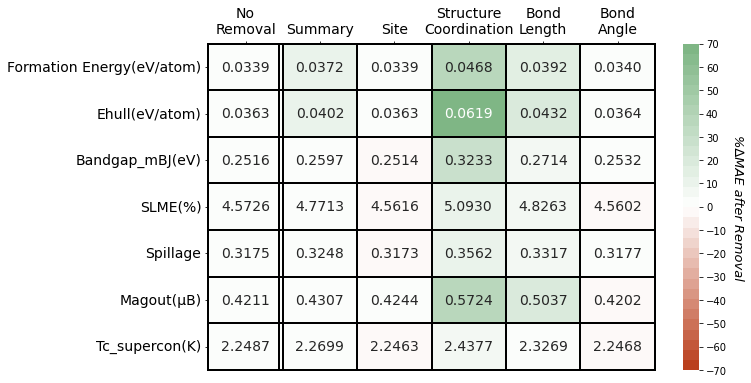

In [4]:
df_text = results_df[skips]
diff_cols = [f"{skip}_diff_percent" for skip in skips[:]]
df_value = results_df[diff_cols]
# Define your RGB hex values
# hex_colors = ["#C25759", "#E69191", "#EDB8B0", "#F5DFDB", "#CCE4EF", "#AECFD4", "#92B5CA", "#599CB4"]
# hex_colors = [ "#C25759", "#E69191", "#EDB8B0", "#F5DFDB"]
hex_colors = ["#BA3F1D","#FFFFFF", "#7FB685"]
# hex_colors.reverse()
# Convert hex colors to normalized RGB tuples
rgb_colors = [tuple(int(h[i:i+2], 16) / 255 for i in (1, 3, 5)) for h in hex_colors]

# Create a continuous colormap
num_colors = 32
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", rgb_colors, N=num_colors)
if text == "robo":
    norm = TwoSlopeNorm(vmin=-70, vcenter=0, vmax=70)
else:
    norm = TwoSlopeNorm(vmin=-120, vcenter=0, vmax=120)

# Create a colormap
# custom_cmap = ListedColormap(rgb_colors)

# Generate some data
def format_func(value, tick_number):
    return f"{'+' if value >= 0 else '-'}{abs(value):.2f}"
# Plot heatmap using the custom colormap
plt.figure(figsize=(10, 6))
# ax = sns.heatmap(df_value, cmap=custom_cmap, vmin=-0.0, vmax=0.2, annot=df_text.values, fmt=".4f", annot_kws={"size": 13},
#     linecolor='black', linewidths=0.5)
ax = sns.heatmap(df_value, cmap=custom_cmap, annot=df_text.values, norm=norm, fmt=".4f", annot_kws={"size": 14},
    linecolor='black', linewidths=1)
    
cbar = ax.collections[0].colorbar
if text == "chemnlp":
    tick_values = [-5, 0, 20, 40, 60, 80, 100, 120]

else:
    tick_values = [-5, 0, 10, 20, 30, 40, 50, 60, 70]

# cbar.set_ticks(tick_values)
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
cbar.ax.set_ylabel('%∆MAE after Removal',rotation=-90, va="bottom", fontsize=13, fontstyle='italic')

cbar.locator = ticker.MaxNLocator(nbins=num_colors/2)  # Set the number of ticks
cbar.update_ticks()

# Set the range of the displayed color bar
# cbar.set_clim(-10, 120)  # Display range for the color bar



ax.xaxis.tick_top()
y_labels = ["Formation Energy(eV/atom)", "Ehull(eV/atom)", "Bandgap_mBJ(eV)", "SLME(%)", "Spillage", "Magout(μB)", "Tc_supercon(K)"]
if text=="robo":
    x_labels = ['No\nRemoval', 'Summary', 'Site', 'Structure\nCoordination', 'Bond\nLength', 'Bond\nAngle']
    
else:
    x_labels = ['No\nRemoval', 'Chemical\ninfo', 'Structure\ninfo', 'Bond\nLength']

ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)
# Set specific linewidth for x and y axes


# # Set specific linewidth for all spines (axes lines)
# for spine in ax.spines.values():
#     spine.set_linewidth(1.0)

# Add thicker line for the right boundary of the first column
ax.axvline(x=1 - 0.05, color='black', linewidth=2)  # First line slightly to the left
# ax.axvline(x=1 + 0.1, color='black', linewidth=2) 
# Customize the x and y axis linewidths
ax.spines['top'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
# font = FontProperties()
# font.set_family('serif')
# font.set_name('Arial')
# font.set_size(12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().spines['bottom'].set_visible(True)  # Show top spine
plt.gca().spines['right'].set_visible(True)  # Show right spine
plt.gca().spines['top'].set_visible(True)  # Show top spine
plt.gca().spines['left'].set_visible(True)  # Show right spine
plt.savefig(f"{text}_heatmap.png", dpi=600, bbox_inches='tight')

plt.show()

### Train/Val Loss Curve

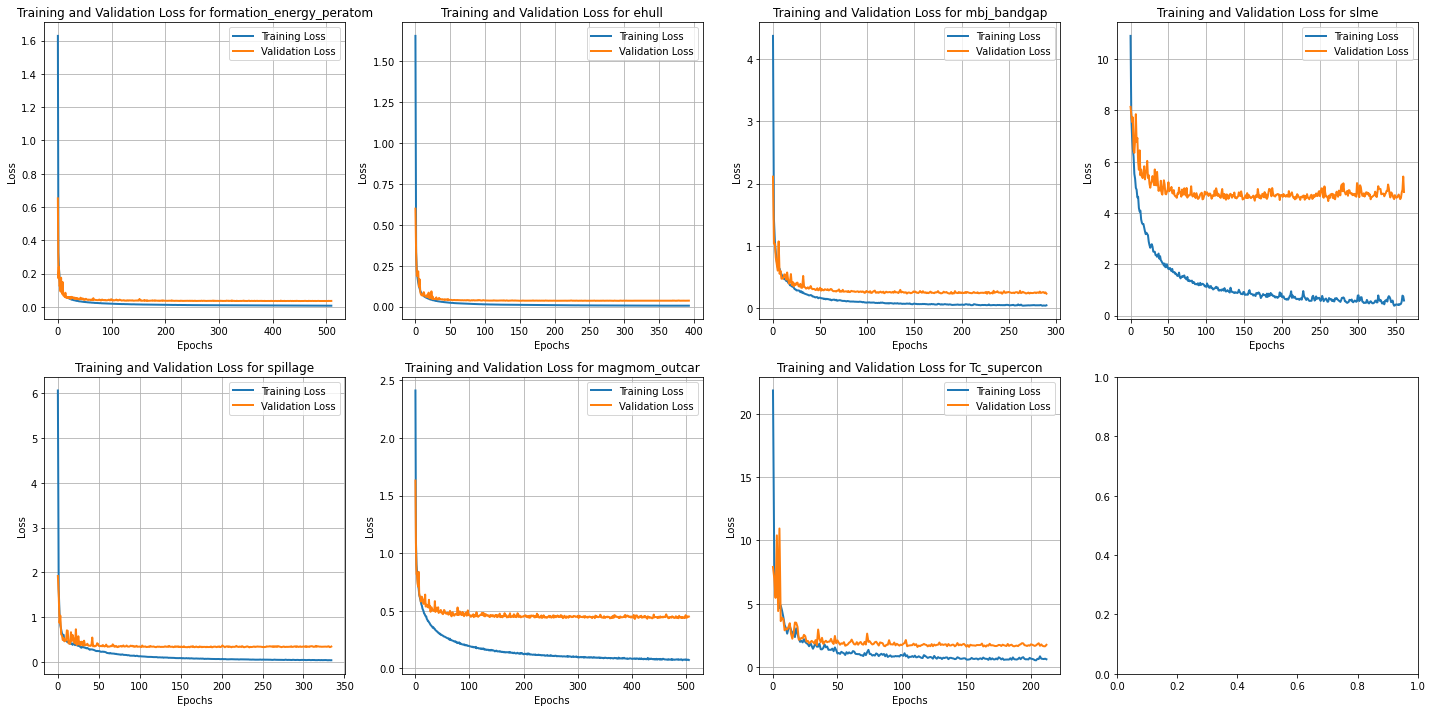

In [18]:
import matplotlib.pyplot as plt
props = [ "formation_energy_peratom", "ehull", "mbj_bandgap", "slme", "spillage", "magmom_outcar", "Tc_supercon"]
# Function to read the log file and extract the loss values
def extract_losses(log_file):
    train_loss = []
    val_loss = []
    with open(log_file, 'r') as file:
        start_training = False
        for line in file:
            if "start training" in line:
                start_training = True
            if start_training and "Current epoch" in line:
                parts = line.split(',')
                for part in parts:
                    if "loss:" in part and "validation" not in part:
                        train_loss.append(float(part.split(':')[1].strip()))
                    if "validation loss:" in part:
                        val_loss.append(float(part.split(':')[1].strip()))
    return train_loss, val_loss

# Path to the log file



num_logs = len(props)

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.flatten()

for i, prop in enumerate(props):
    # Extract losses
    log_file = f'/scratch/yll6162/CrossPropertyTL/elemnet/log/alignn_matbert-base-cased_robo_prop_{prop}.log'
    train_loss, val_loss = extract_losses(log_file)
    
    # Extract property name from the log file path
    prop_name = prop
    
    # Plot the loss curves
    axs[i].plot(train_loss, label='Training Loss', linewidth=2)
    axs[i].plot(val_loss, label='Validation Loss', linewidth=2)
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'Training and Validation Loss for {prop_name}')
    axs[i].grid()
    axs[i].legend()

# Adjust layout
plt.tight_layout()
plt.savefig("train_val_loss_curve.png", dpi=300)
plt.show()
